In [1]:
import catboost

In [2]:
reg = catboost.CatBoostRegressor()

In [3]:
reg.load_model('../models/M032-0703_2133-2JHH-3.model')

In [7]:
import pandas as pd
fold_importance = pd.DataFrame()
fold_importance["feature"] = reg.feature_names_
fold_importance["importance"] = reg.get_feature_importance()
fold_importance["type"] = bond_type
fold_importance["fold"] = fold_n + 1
feature_importance = pd.concat(
    [feature_importance, fold_importance], axis=0)



NameError: name 'bond_type' is not defined

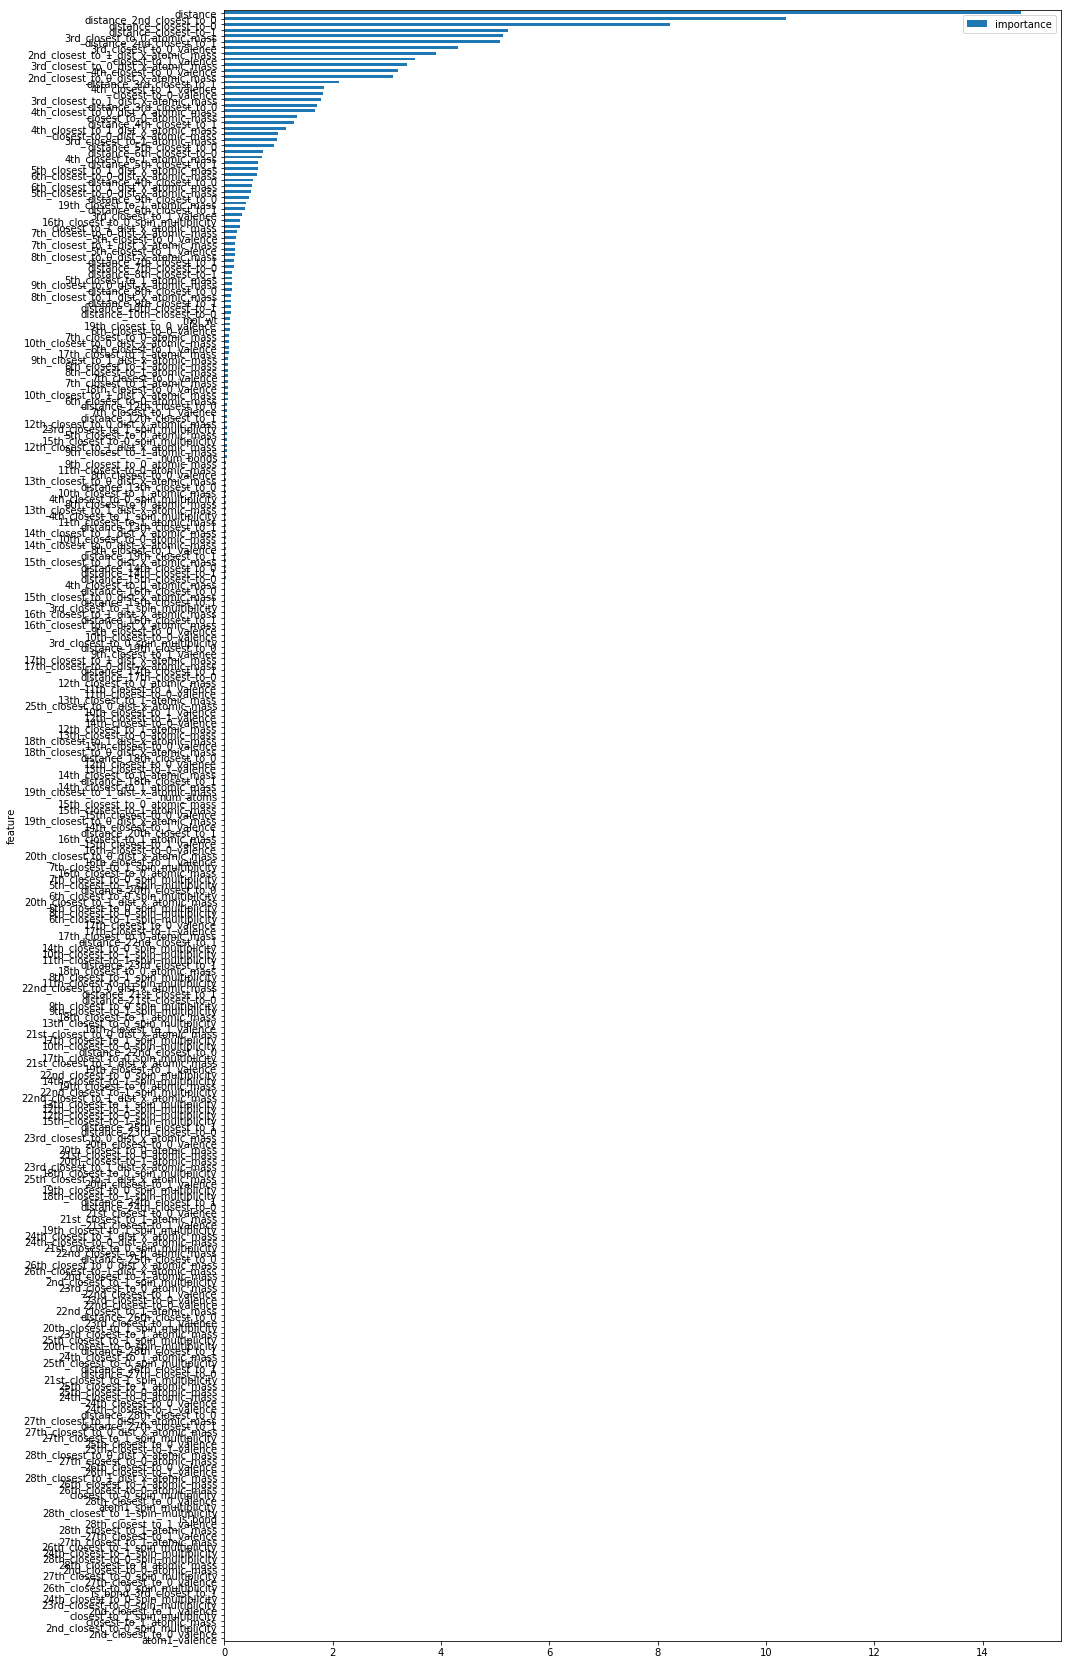

In [14]:
fold_importance.set_index('feature').sort_values('importance', ascending=True).plot(kind='barh', figsize=(15, 30))

In [6]:
reg.feature_names_

['atom1_valence',
 'atom1_spin_multiplicity',
 'distance',
 'is_bond',
 'distance_closest_to_0',
 'distance_2nd_closest_to_0',
 'distance_3rd_closest_to_0',
 'distance_4th_closest_to_0',
 'distance_5th_closest_to_0',
 'distance_6th_closest_to_0',
 'distance_7th_closest_to_0',
 'distance_8th_closest_to_0',
 'distance_9th_closest_to_0',
 'distance_10th_closest_to_0',
 'distance_closest_to_1',
 'distance_2nd_closest_to_1',
 'distance_3rd_closest_to_1',
 'is_bond_3rd_closest_to_1',
 'distance_4th_closest_to_1',
 'distance_5th_closest_to_1',
 'distance_6th_closest_to_1',
 'distance_7th_closest_to_1',
 'distance_8th_closest_to_1',
 'distance_9th_closest_to_1',
 'distance_10th_closest_to_1',
 'closest_to_0_atomic_mass',
 'closest_to_0_valence',
 'closest_to_0_spin_multiplicity',
 '2nd_closest_to_0_atomic_mass',
 '2nd_closest_to_0_valence',
 '2nd_closest_to_0_spin_multiplicity',
 '3rd_closest_to_0_atomic_mass',
 '3rd_closest_to_0_valence',
 '3rd_closest_to_0_spin_multiplicity',
 '4th_closest_t

In [5]:
reg.get_feature_importance()

[0.0,
 0.0,
 14.71783938197977,
 0.0,
 8.22446248100724,
 10.372939216020301,
 1.71800106603362,
 0.5238407933290085,
 0.9173973237421466,
 0.7071694800848145,
 0.17275491971779577,
 0.14069986328160167,
 0.4493059712921373,
 0.1160531646781771,
 5.235518660665847,
 5.099045728154273,
 2.1255278025626945,
 0.0,
 1.2829918788737558,
 0.6304289300436365,
 0.3866860682493713,
 0.1769280883297182,
 0.1474451200373823,
 0.11881818497820609,
 0.11859784896682915,
 1.3467558513650708,
 1.8236788919542808,
 0.0,
 0.0,
 0.0,
 0.0,
 5.146130135819131,
 4.320395097458081,
 0.012932015405695128,
 0.021585413536539137,
 3.198300418112759,
 0.03349627352649828,
 0.04568455912139811,
 0.21305811248212306,
 0.001540846989670652,
 0.058908243341563436,
 0.09705950419338354,
 0.0016512524013132467,
 0.08861436558203288,
 0.06890440961912712,
 0.0019777306734521886,
 0.032862550581701844,
 0.038399861205532466,
 0.0014017247743713485,
 0.0394531078773655,
 0.015768408827564362,
 0.0005552415987482531,
 0